In [1]:
import warnings
warnings.simplefilter('ignore')

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.sans-serif'] = 'SimHei' # 设置中文显示
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler =StandardScaler()
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
day_df = pd.read_csv("train\A-入库流量（2014-2019）.csv", encoding='utf-8')
day_df['TIME'] = pd.to_datetime(day_df['TIME'], errors='coerce')
day_df = day_df[['TIME', 'V']]
day_df['V'][day_df['V'] < 0] = 0

day_df.head(43803)

,TIME,V
0,2014-01-01 00:00:00,67.637
1,2014-01-01 01:00:00,67.637
2,2014-01-01 02:00:00,680.319
3,2014-01-01 03:00:00,326.687
4,2014-01-01 04:00:00,112.119
...,...,...
43798,2018-12-31 21:00:00,1831.094
43799,2018-12-31 22:00:00,1077.106
43800,2018-12-31 23:00:00,2311.973
43801,2019-01-01 00:00:00,964.838


In [3]:
# 生成完整时间范围（以小时为颗粒度）
full_time_range = pd.date_range(start=day_df['TIME'].min(), end=day_df['TIME'].max(), freq='H')

# 将完整时间范围与现有数据对齐
df = day_df.set_index('TIME').reindex(full_time_range).rename_axis('TIME').reset_index()

# 填充缺失的行
missing_date = '2014-06-30'
previous_date = '2014-06-29'

# 找到前一天的所有数据
previous_day_data = df[df['TIME'].dt.strftime('%Y-%m-%d') == previous_date]

# 使用前一天的数据填充缺失日期
for i in range(24):  # 每小时一个值
    missing_time = pd.Timestamp(f'{missing_date} {i}:00:00')
    if missing_time in df['TIME'].values:  # 确保只有缺失的被替换
        #df.loc[df['TIME'] == missing_time, 'V'] = previous_day_data.iloc[i]['V']
        df.loc[df['TIME'] == missing_time, 'V'] = 0

#print(df[df['TIME'].dt.strftime('%Y-%m-%d') == missing_date])  # 检查结果

day_df = df
len(df)


52584

In [4]:
a_df = pd.read_csv("train\A-雨量水位（2014-2019）.csv", encoding='utf-8')
a_df['TIME'] = pd.to_datetime(a_df['TIME'])
a_df = a_df.sort_values(by=['NAME','TIME'], ascending=True)
# 将时间向下取整到小时
a_df['TIME'] = a_df['TIME'].dt.floor('H')
a_df['V'][a_df['V'] < 0] = 0
a_df['MAXV'][a_df['MAXV'] < 0] = 0
station_ids_to_keep = [1108193, 1110036, 1110035, 1221654, 1221354, 1510254, 1221254]

# 筛选保留的站点数据
id_data = a_df[a_df['SENID'].isin(station_ids_to_keep)]
id_data = id_data[['TIME','SENID','V']]



a_df = a_df.groupby(['TIME']).agg({'V': 'sum','MAXV': 'sum'}).reset_index()

for senid in station_ids_to_keep:
    # 筛选当前 SENID 的数据
    temp_df = id_data[id_data['SENID'] == senid].copy()
    temp_df = temp_df.drop('SENID',axis=1)
    temp_df['V'][temp_df['V']<0] = 0
    
    # 执行合并操作
    a_df = pd.merge(a_df, temp_df, on='TIME', how='left',suffixes=('', f'_{senid}')).fillna(0)


# a_df.rename(columns={a_df.columns[0]: "AV"}, inplace=True)
a_df = a_df.drop(['TIME','V','MAXV'],axis=1)
print(a_df.sum())
a_df

V_1108193    10283.665
V_1110036    11000.982
V_1110035    11467.212
V_1221654    11749.000
V_1221354    10523.000
V_1510254    10458.000
V_1221254    10398.000
dtype: float64


,V_1108193,V_1110036,V_1110035,V_1221654,V_1221354,V_1510254,V_1221254
0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
1,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,0.00,0.00,0.0,0.0,0.0,0.0,0.0
3,0.00,0.00,0.0,0.0,0.0,0.0,0.0
4,0.00,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
52579,0.02,0.06,0.0,0.0,0.0,0.0,0.0
52580,0.00,0.00,0.0,0.0,0.0,0.0,0.0
52581,0.01,0.00,0.0,0.0,0.0,0.0,0.0
52582,0.00,0.00,0.0,0.0,0.0,0.0,0.0


In [5]:
b_df = pd.read_csv("test\A-雨量水位（2020-2021）.csv", encoding='utf-8')
b_df['TIME'] = pd.to_datetime(b_df['TIME'])
b_df = b_df.sort_values(by=['NAME','TIME'], ascending=True)
# 将时间向下取整到小时
b_df['TIME'] = b_df['TIME'].dt.floor('H')
b_df['V'][b_df['V'] < 0] = 0
b_df['MAXV'][b_df['MAXV'] < 0] = 0


id_data = b_df[b_df['SENID'].isin(station_ids_to_keep)]
id_data = id_data[['TIME','SENID','V']]
b_df = b_df.groupby(['TIME']).agg({'V': 'sum','MAXV': 'sum'}).reset_index()


for senid in station_ids_to_keep:
    # 筛选当前 SENID 的数据
    temp_df = id_data[id_data['SENID'] == senid].copy()
    temp_df = temp_df.drop('SENID',axis=1)
    #print(temp_df['V'].sum())
    
    # 执行合并操作
    b_df = pd.merge(b_df, temp_df, on='TIME', how='left',suffixes=('', f'_{senid}')).fillna(0)


#b_df.rename(columns={b_df.columns[0]: "AV"}, inplace=True)
b_df = b_df.drop(['TIME','V','MAXV'],axis=1)

b_df

,V_1108193,V_1110036,V_1110035,V_1221654,V_1221354,V_1510254,V_1221254
0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
1,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,0.00,0.00,0.0,0.0,0.0,0.0,0.0
3,0.03,0.11,0.0,0.0,0.0,0.0,0.0
4,0.00,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
17539,0.00,0.00,0.0,0.0,0.0,0.0,0.0
17540,0.00,0.00,0.0,0.0,0.0,0.0,0.0
17541,0.00,0.00,0.0,0.0,0.0,0.0,0.0
17542,0.00,0.00,0.0,0.0,0.0,0.0,0.0


In [6]:
def cal_range(x):

    return x.max() - x.min()

def increase_num(x):

    return (x.diff() > 0).sum()

def decrease_num(x):

    return (x.diff() < 0).sum()

def increase_mean(x):

    diff = x.diff()
    return diff[diff > 0].mean()

def decrease_mean(x):

    diff = x.diff()
    return diff[diff < 0].abs().mean()

def increase_std(x):

    diff = x.diff()
    return diff[diff > 0].std()

def decrease_std(x):

    diff = x.diff()
    return diff[diff < 0].std()



In [7]:
# window_sizes = [4,6,12,24]#16?

# with tqdm(window_sizes) as pbar:
#     for window_size in pbar:

#         functions = ["mean", "std", "min", "max", cal_range, increase_num,
#                      #decrease_num, increase_mean, decrease_mean, increase_std, decrease_std,
#                      #increase_nunique,decrease_nunique,increase_jfg,decrease_jfg
#                     ]

#         for func in functions:
#             func_name = func if type(func) == str else func.__name__

#             column_name = f"demand_rolling_{window_size}_{func_name}"

#             a_df[column_name] = a_df["AV"].rolling(
#                 window=window_size,        
#                 min_periods=window_size//2,  
#                 closed="left"         
#             ).agg(func)             

#             pbar.set_postfix({"window_size": window_size, "func": func_name})

In [8]:
# window_sizes = [4,6,12,24]#16?

# with tqdm(window_sizes) as pbar:
#     for window_size in pbar:

#         functions = ["mean", "std", "min", "max", cal_range, increase_num,
#                      #decrease_num, increase_mean, decrease_mean, increase_std, decrease_std,
#                      #increase_nunique,decrease_nunique,increase_jfg,decrease_jfg
#                     ]

#         for func in functions:
#             func_name = func if type(func) == str else func.__name__

#             column_name = f"demand_rolling_{window_size}_{func_name}"

#             b_df[column_name] = b_df["AV"].rolling(
#                 window=window_size,        
#                 min_periods=window_size//2,  
#                 closed="left"         
#             ).agg(func)             

#             pbar.set_postfix({"window_size": window_size, "func": func_name})

In [9]:
def calculate_best_lag_for_dataframe(dataframe, target, lags):
    best_lags = []  # 用于存储所有列的最佳滞后阶数
    
    for column in dataframe.columns:
        # 当前列的时间序列数据
        series = dataframe[column]
        
        # 存储当前列的滞后相关性
        correlations = {}
        
        for lag in lags:
            # 计算滞后值
            lag_series = series.shift(lag)
            
            # 计算相关性（排除NaN值）
            correlation = target.corr(lag_series)
            correlations[lag] = correlation  # 保存相关性
        
        # 找到当前列的最佳滞后阶数
        best_lag = max(correlations, key=correlations.get)
        
        # 将最佳滞后阶数添加到列表中
        best_lags.append(best_lag)
    
    return best_lags

# 调用函数
lags = list(range(0, 96))
best_lags = calculate_best_lag_for_dataframe(a_df, day_df['V'], lags)

columns_to_lag = a_df.columns

# 打印最佳滞后阶数列表
print(f"最佳滞后阶数列表: {best_lags}")
print(f"最佳滞后阶数列表: {columns_to_lag}")


最佳滞后阶数列表: [22, 24, 23, 21, 20, 20, 20]
最佳滞后阶数列表: Index(['V_1108193', 'V_1110036', 'V_1110035', 'V_1221654', 'V_1221354',
       'V_1510254', 'V_1221254'],
      dtype='object')


In [10]:
def features_build(df):
    date_col = df['TIME']
    df["hour"] = date_col.dt.hour.fillna(-1)
    df["day"] = date_col.dt.day.fillna(-1)
    df["month"] = date_col.dt.month.fillna(-1)
    #df["dayofweek"] = date_col.dt.dayofweek.fillna(-1)
    #df["dayofyear"] = date_col.dt.dayofyear.fillna(-1)

    df['flow'] = df['month'].isin([5,6,7]).astype(int)
    df['rain'] = df['month'].isin([6,7]).astype(int) 
    df['typhoon'] = df['month'].isin([10,11,12]).astype(int)     
    df["quarter"] = date_col.dt.quarter.fillna(-1)

    df['_hour_sin'] = df["hour"] * np.sin(2 * np.pi * df["hour"]/24)
    df['_hour_cos'] = df["hour"] * np.cos(2 * np.pi * df["hour"]/24)
    df['_month_sin'] = df["month"] * np.sin(2 * np.pi * df["month"]/12)
    df['_month_cos'] = df["month"] * np.cos(2 * np.pi * df["month"]/12)
    df['_day_sin'] = df["day"] * np.sin(2 * np.pi * df["day"]/30)
    df['_day_cos'] = df["day"] * np.cos(2 * np.pi * df["day"]/30)

    # df['_dayofyear_sin'] = df["day"] * np.sin(2 * np.pi * df["dayofyear"]/365)
    # df['_dayofyear_cos'] = df["day"] * np.cos(2 * np.pi * df["dayofyear"]/365)

    
    df['AV'] = 0
    for col, lag in zip(columns_to_lag, best_lags):
        #df[col][df[col]<0] = 0
        df[f"{col}_lag{lag}"] = df[col].shift(lag)
        df['AV'] += df[f"{col}_lag{lag}"]

    #df["MAXAV-24"] = df["MAXV"].shift(22)
    # df["AV-25"] = df["AV"].shift(25) - df["AV"]
    # df["AV-8"] = df["AV"].shift(8) - df["AV"]
    df['AV_diff'] = df['AV'].diff()

    df['V_ewm005_mean'] = df['AV'].ewm(alpha=0.05).mean()
    #df['V_rolling3_mean'] = df['AV'].rolling(window=3).mean()
    df['V_zscore'] = (df['AV'] - df['AV'].mean()) / (df['AV'].std() + 1e-10)


    #df = df.apply(lambda col: col.fillna(col.mean()))
    df = df.apply(lambda col: col.fillna(0))
    df = df.drop(['TIME'], axis=1)
    df = df.drop(columns=columns_to_lag)
    df.drop(columns=[f"{col}_lag{lag}" for col, lag in zip(columns_to_lag, best_lags)], inplace=True)

    return df


In [11]:
features = pd.concat([a_df,day_df],axis=1)
features = features_build(features)
target = day_df["V"]
features



,V,hour,day,month,flow,rain,typhoon,quarter,_hour_sin,_hour_cos,_month_sin,_month_cos,_day_sin,_day_cos,AV,AV_diff,V_ewm005_mean,V_zscore
0,67.637,0,1,1,0,0,0,1,0.000000,0.000000,5.000000e-01,0.866025,0.207912,0.978148,0.00,0.00,0.000000,0.000000
1,67.637,1,1,1,0,0,0,1,0.258819,0.965926,5.000000e-01,0.866025,0.207912,0.978148,0.00,0.00,0.000000,0.000000
2,680.319,2,1,1,0,0,0,1,1.000000,1.732051,5.000000e-01,0.866025,0.207912,0.978148,0.00,0.00,0.000000,0.000000
3,326.687,3,1,1,0,0,0,1,2.121320,2.121320,5.000000e-01,0.866025,0.207912,0.978148,0.00,0.00,0.000000,0.000000
4,112.119,4,1,1,0,0,0,1,3.464102,2.000000,5.000000e-01,0.866025,0.207912,0.978148,0.00,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,385.296,19,31,12,0,0,1,4,-18.352591,4.917562,-2.939152e-15,12.000000,6.445262,30.322576,0.01,0.01,0.002093,-0.294836
52580,607.572,20,31,12,0,0,1,4,-17.320508,10.000000,-2.939152e-15,12.000000,6.445262,30.322576,0.08,0.07,0.005989,-0.280432
52581,801.849,21,31,12,0,0,1,4,-14.849242,14.849242,-2.939152e-15,12.000000,6.445262,30.322576,0.00,-0.08,0.005689,-0.296894
52582,1024.193,22,31,12,0,0,1,4,-11.000000,19.052559,-2.939152e-15,12.000000,6.445262,30.322576,1.01,1.01,0.055905,-0.089070


In [12]:
test_submit = pd.read_csv("submit.csv", encoding='utf-8')
test_submit['TIME'] = pd.to_datetime(test_submit['TIME'], errors='coerce')


#test_df = test_df.drop(['TIME','V'], axis=1)
test_df = pd.concat([b_df,test_submit],axis=1)
test_df = features_build(test_df)
# test_df.loc[3030:3066, 'AV'] -= 55
# test_df['AV'] = test_df['AV'].clip(lower=0)
test_df = test_df.drop(['V'],axis=1)
test_df

,hour,day,month,flow,rain,typhoon,quarter,_hour_sin,_hour_cos,_month_sin,_month_cos,_day_sin,_day_cos,AV,AV_diff,V_ewm005_mean,V_zscore
0,0,1,1,0,0,0,1,0.000000,0.000000,5.000000e-01,0.866025,0.207912,0.978148,0.0,0.00,0.000000,0.000000
1,1,1,1,0,0,0,1,0.258819,0.965926,5.000000e-01,0.866025,0.207912,0.978148,0.0,0.00,0.000000,0.000000
2,2,1,1,0,0,0,1,1.000000,1.732051,5.000000e-01,0.866025,0.207912,0.978148,0.0,0.00,0.000000,0.000000
3,3,1,1,0,0,0,1,2.121320,2.121320,5.000000e-01,0.866025,0.207912,0.978148,0.0,0.00,0.000000,0.000000
4,4,1,1,0,0,0,1,3.464102,2.000000,5.000000e-01,0.866025,0.207912,0.978148,0.0,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,19,31,12,0,0,1,4,-18.352591,4.917562,-2.939152e-15,12.000000,6.445262,30.322576,0.0,-0.01,0.137342,-0.289326
17540,20,31,12,0,0,1,4,-17.320508,10.000000,-2.939152e-15,12.000000,6.445262,30.322576,0.0,0.00,0.130474,-0.289326
17541,21,31,12,0,0,1,4,-14.849242,14.849242,-2.939152e-15,12.000000,6.445262,30.322576,0.0,0.00,0.123951,-0.289326
17542,22,31,12,0,0,1,4,-11.000000,19.052559,-2.939152e-15,12.000000,6.445262,30.322576,0.0,0.00,0.117753,-0.289326


In [13]:
# window_sizes = [3,6,12,24]#16?

# with tqdm(window_sizes) as pbar:
#     for window_size in pbar:

#         functions = ["sum","mean"]

#         for func in functions:
#             func_name = func if type(func) == str else func.__name__

#             column_name = f"demand_rolling_{window_size}_{func_name}"

#             features[column_name] = features["AV"].rolling(
#                 window=window_size,        
#                 min_periods=window_size//2,  
#                 closed="left"         
#             ).agg(func).fillna(0)        

#             pbar.set_postfix({"window_size": window_size, "func": func_name})

In [14]:
# window_sizes = [3,6,12,24]

# with tqdm(window_sizes) as pbar:
#     for window_size in pbar:

#         functions = ["sum","mean"]

#         for func in functions:
#             func_name = func if type(func) == str else func.__name__

#             column_name = f"demand_rolling_{window_size}_{func_name}"

#             test_df[column_name] = test_df["AV"].rolling(
#                 window=window_size,        
#                 min_periods=window_size//2,  
#                 closed="left"         
#             ).agg(func).fillna(0)      

#             pbar.set_postfix({"window_size": window_size, "func": func_name})

In [15]:
features

,V,hour,day,month,flow,rain,typhoon,quarter,_hour_sin,_hour_cos,_month_sin,_month_cos,_day_sin,_day_cos,AV,AV_diff,V_ewm005_mean,V_zscore
0,67.637,0,1,1,0,0,0,1,0.000000,0.000000,5.000000e-01,0.866025,0.207912,0.978148,0.00,0.00,0.000000,0.000000
1,67.637,1,1,1,0,0,0,1,0.258819,0.965926,5.000000e-01,0.866025,0.207912,0.978148,0.00,0.00,0.000000,0.000000
2,680.319,2,1,1,0,0,0,1,1.000000,1.732051,5.000000e-01,0.866025,0.207912,0.978148,0.00,0.00,0.000000,0.000000
3,326.687,3,1,1,0,0,0,1,2.121320,2.121320,5.000000e-01,0.866025,0.207912,0.978148,0.00,0.00,0.000000,0.000000
4,112.119,4,1,1,0,0,0,1,3.464102,2.000000,5.000000e-01,0.866025,0.207912,0.978148,0.00,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,385.296,19,31,12,0,0,1,4,-18.352591,4.917562,-2.939152e-15,12.000000,6.445262,30.322576,0.01,0.01,0.002093,-0.294836
52580,607.572,20,31,12,0,0,1,4,-17.320508,10.000000,-2.939152e-15,12.000000,6.445262,30.322576,0.08,0.07,0.005989,-0.280432
52581,801.849,21,31,12,0,0,1,4,-14.849242,14.849242,-2.939152e-15,12.000000,6.445262,30.322576,0.00,-0.08,0.005689,-0.296894
52582,1024.193,22,31,12,0,0,1,4,-11.000000,19.052559,-2.939152e-15,12.000000,6.445262,30.322576,1.01,1.01,0.055905,-0.089070


In [16]:
def prepare_data(data):
    X = []
    y = []

    #features = data  
    features = data.drop(['V'], axis=1).values  
    target = np.log(data["V"].values+1)

    X = np.asarray(features)
    X = np.expand_dims(X, axis=-2)
    y = np.asarray(target)

    return X, y

train_X, train_y= prepare_data(features)


X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.3,random_state=42,shuffle=False) 

#使用24小时作为时间窗口
# look_back = 24
# #创建训练集的LSTM输入格式
# X_train = np.array([X_train[i:i+look_back] for i in range(len(X_train)-look_back)])
# y_train = np.array([y_train[i+look_back] for i in range(len(y_train)-look_back)])
# #创建测试集的LSTM输入格式
# X_val = np.array([X_val[i:i+look_back] for i in range(len(X_val)-look_back)])
# y_val = np.array([y_val[i+look_back] for i in range(len(y_val)-look_back)])

print("训练集形状:", X_train.shape, y_train.shape)

训练集形状: (36808, 1, 17) (36808,)


In [17]:
train_y

array([4.22883175, 4.22883175, 6.52403063, ..., 6.68816665, 6.93263617,
       6.93194142])

In [18]:

import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_validation_tensor=torch.tensor(X_val, dtype=torch.float32).to(device)
y_validation_tensor= torch.tensor(y_val,dtype=torch.float32).to(device)

test_df = np.asarray(test_df)
test_df = np.expand_dims(test_df, axis=-2)
X_test_tensor = torch.tensor(test_df, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)



batch_size = 24


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print('Sample input shape: ', sample_x.shape)
print('Sample output shape: ', sample_y.shape)

Sample input shape:  torch.Size([24, 1, 17])
Sample output shape:  torch.Size([24])


In [19]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

# 定义模型参数字典
model_params = {
    'lstm': {
        'input_size': 17,  # 输入特征维度
        'hidden_size': 128,              # LSTM隐藏层维度
        'num_layers': 2,                 # LSTM层数
        'dropout': 0.3,
        'output_size': 1                 # 输出维度
    }
}

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, params):
        super(LSTMModel, self).__init__()
        self.hidden_size = params['hidden_size']
        self.num_layers = params['num_layers']
        # 定义LSTM层
        self.lstm = nn.LSTM(params['input_size'], params['hidden_size'], params['num_layers'], batch_first=True)
        self.batch_norm = nn.BatchNorm1d(params['hidden_size'])
        self.dropout = nn.Dropout(p=params['dropout'])
        # 定义全连接层
        self.fc1 = nn.Linear(params['hidden_size'], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, params['output_size'])
        self.relu = nn.ReLU()  # 激活函数ReLU

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(out[:, -1, :])  # 取最后一个时间步的输出，并应用ReLU激活函数
        out = self.relu(self.fc1(out))  # 全连接层1

        out = self.relu(self.fc2(out))  # 全连接层2

        out = self.relu(self.fc3(out))  # 全连接层3

        out = self.relu(self.fc4(out))  # 全连接层4
        #out = self.dropout(out) 
        out = self.fc5(out)  # 输出层
        return out
    
# 初始化模型
lstm_model = LSTMModel(model_params['lstm']).to(device)

#print(lstm_model)

Epoch [1/50], Train Loss: 2.36, Val Loss: 2.30
Epoch [2/50], Train Loss: 1.12, Val Loss: 1.50
Epoch [3/50], Train Loss: 0.90, Val Loss: 1.46
Epoch [4/50], Train Loss: 0.82, Val Loss: 1.50
Epoch [5/50], Train Loss: 0.75, Val Loss: 1.44
Epoch [6/50], Train Loss: 0.71, Val Loss: 1.46
Epoch [7/50], Train Loss: 0.68, Val Loss: 1.55
Epoch [8/50], Train Loss: 0.66, Val Loss: 1.51
Epoch [9/50], Train Loss: 0.64, Val Loss: 1.51
Epoch [10/50], Train Loss: 0.63, Val Loss: 1.51
Epoch [11/50], Train Loss: 0.62, Val Loss: 1.68
Epoch [12/50], Train Loss: 0.61, Val Loss: 1.89
Epoch [13/50], Train Loss: 0.61, Val Loss: 1.65
Epoch [14/50], Train Loss: 0.60, Val Loss: 1.62
Epoch [15/50], Train Loss: 0.60, Val Loss: 1.64
Epoch [16/50], Train Loss: 0.60, Val Loss: 1.61
Epoch [17/50], Train Loss: 0.59, Val Loss: 1.66
Epoch [18/50], Train Loss: 0.60, Val Loss: 1.68
Epoch [19/50], Train Loss: 0.60, Val Loss: 1.66
Epoch [20/50], Train Loss: 0.60, Val Loss: 1.60
Epoch [21/50], Train Loss: 0.60, Val Loss: 1.62
E

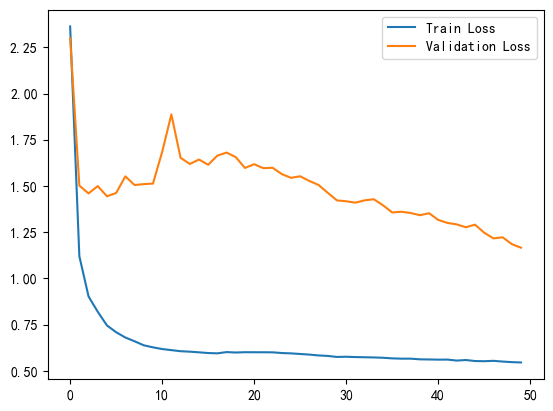

In [20]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()  # 使用 PyTorch 内置 MSE 损失函数
    
    def forward(self, prediction, target):
        mse_loss = self.mse(prediction, target)
        rmse_loss = torch.sqrt(mse_loss)
        return rmse_loss
#criterion = RMSELoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
#optimizer = optim.AdamW(lstm_model.parameters(), lr=0.001,weight_decay=0.05)


num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    lstm_model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    lstm_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = lstm_model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}')


plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [30]:

torch.save(lstm_model.state_dict(), 'lstm_model.pth')

lstm_model = LSTMModel(model_params['lstm']).to(device)
lstm_model.load_state_dict(torch.load('lstm_model.pth'))
lstm_model.eval()
# 在测试集上进行预测
predictions = []
lstm_model.eval()
with torch.no_grad():
    for inputs, _ in val_loader:
        outputs = lstm_model(inputs)
        predictions.extend(outputs.cpu().numpy())

predictions = np.array(predictions)
predictions = predictions.flatten()
predictions = np.exp(predictions - 1)  # 将目标值加 1 后再取对数

predictions

array([310.2779 , 248.59895, 256.68805, ..., 181.13292, 179.52667,
       130.6169 ], dtype=float32)

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_actual = np.exp(y_val -1)
y_predicted = predictions*5

rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))

print(f'RMSE: {rmse:.2f}')
print(f'本地分数: {1/(1+rmse)}')

RMSE: 1077.63
本地分数: 0.0009271020521388638


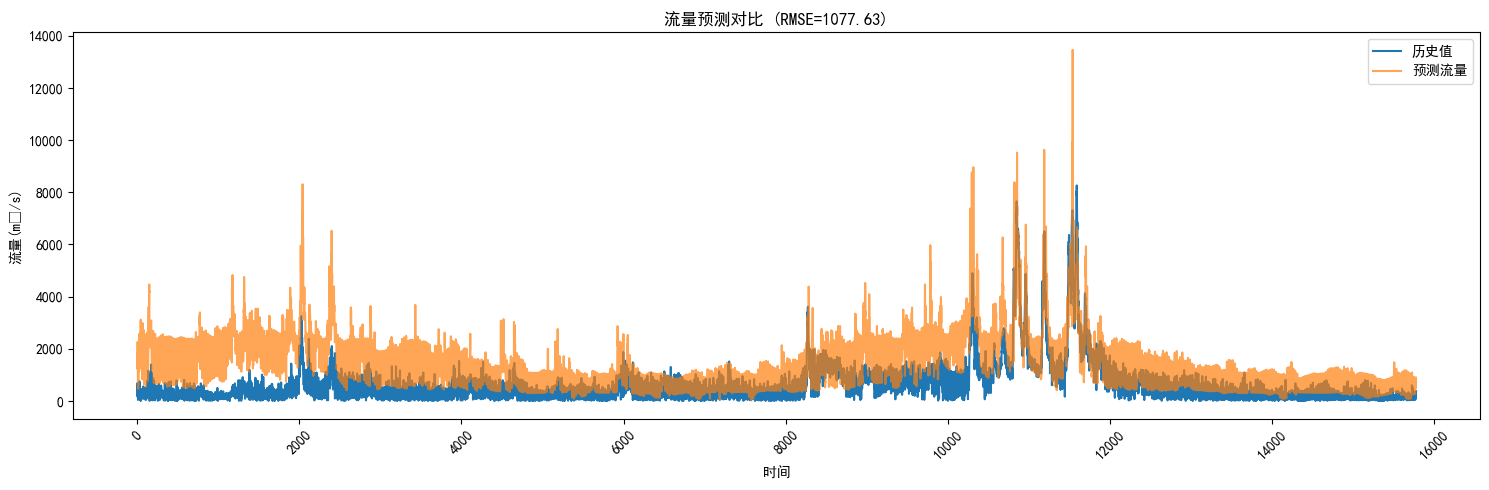

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual, label='历史值')
plt.plot(y_predicted, label='预测流量', alpha=0.7)
plt.title(f'流量预测对比 (RMSE={rmse:.2f})')
plt.xlabel('时间')
plt.ylabel('流量(m³/s)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
with torch.no_grad():  # 禁用梯度计算，提高效率
    predictions = lstm_model(X_test_tensor)
    predictions = predictions.cpu().numpy()
    predictions = predictions.flatten()
    predictions = np.exp(predictions - 1)

print(predictions)


[ 78.989815  73.35268   67.54695  ... 183.42273  173.37436  132.55696 ]


In [25]:
y_pred = pd.DataFrame(predictions*5)
y_pred

,0
0,394.949066
1,366.763367
2,337.734741
3,289.070801
4,251.686401
...,...
17539,716.417480
17540,856.730835
17541,917.113647
17542,866.871826


In [26]:
submit = pd.read_csv("submit.csv", encoding='utf-8')
submit["V"] = y_pred 
submit.to_csv('result_lstm.csv',index=False)
submit

,TIME,V
0,2020-01-01 00:00:00,394.949066
1,2020-01-01 01:00:00,366.763367
2,2020-01-01 02:00:00,337.734741
3,2020-01-01 03:00:00,289.070801
4,2020-01-01 04:00:00,251.686401
...,...,...
17539,2021-12-31 19:00:00,716.417480
17540,2021-12-31 20:00:00,856.730835
17541,2021-12-31 21:00:00,917.113647
17542,2021-12-31 22:00:00,866.871826


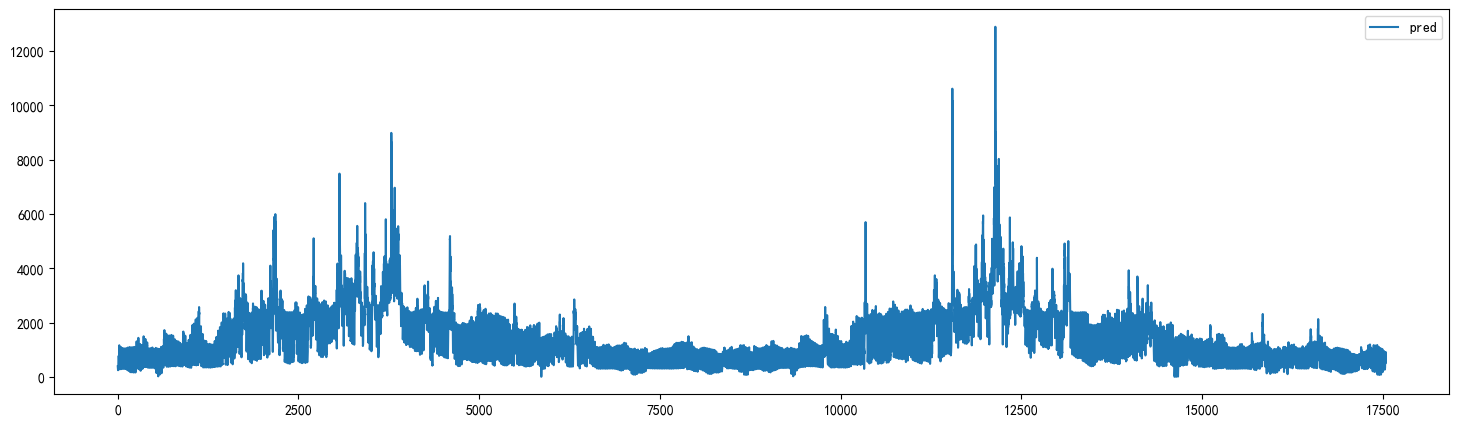

In [27]:
plt.figure(figsize=(18,5))
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()